In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:

def plot(img):
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()

def filter_image(image, mask):
        r = image[:,:,0] * mask
        g = image[:,:,1] * mask
        b = image[:,:,2] * mask
        return np.dstack([r,g,b])

def edgesx(img,blur):
    h=1
    new_img=np.zeros((len(img),len(img[1])),dtype=np.uint8)
    for i in range(0,len(img)):
        derivative=[]
        #print('raw ',i)
        for j in range(len(blur[1])-1):
            der=(blur[i][j+h]-blur[i][j])/h
            if der>200:
                derivative.append(der-255)
            else:
                derivative.append(der)
        for d in range(len(derivative)-1):
            a=derivative[d]
            b=derivative[d+1]
            if a==1 and b==0:
                derivative[d]=0
        for d in range(len(derivative)):
            if derivative[d]!=0:
                new_img[i][d]=255
    return new_img
        
def edgesy(img,blur):
    h=1
    y_img=np.zeros((len(img),len(img[1])),dtype=np.uint8)
    for col in range(len(img[1])):
        derivative=[]
        for row in range(len(img)-1):
            der=(blur[row+h][col]-blur[row][col])/h
            if der>200:
                derivative.append(der-255)
            else:
                derivative.append(der)
        for d in range(len(derivative)-1):
            a=derivative[d]
            b=derivative[d+1]
            if a==1 and b==0:
                derivative[d]=0
        for d in range(len(derivative)):
            if derivative[d]!=0:
                y_img[d][col]=255
    return y_img

In [3]:
#load an image
img=cv.imread('\\skin_test18.jpg')
img2=np.copy(img)

Step 1: coinvert to grayscale the image so, from a multy dimensional vector (R,G,B), to be tranformed into 1 dimension vector

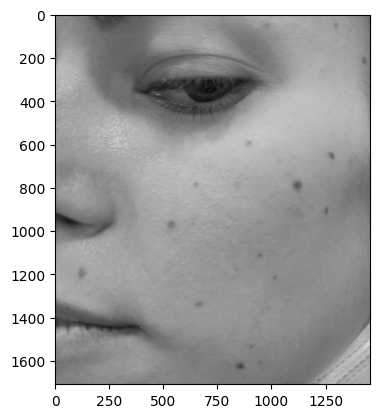

In [5]:

gray1=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plot(gray1)

Step 2: Blur the image, using Gaussian smothing filter

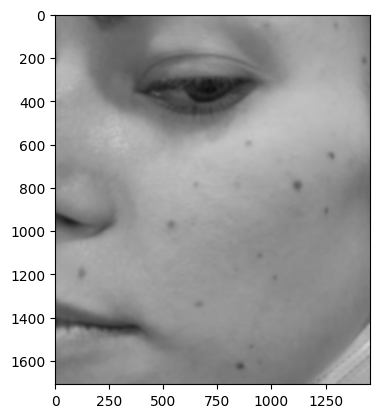

In [6]:
blur=cv.GaussianBlur(gray1,(31,31),0)
plot(blur)

Step 3: find the edges using first order derivative for each axis, and by summing it will produce a binary image with the edges white

C:\Users\GeorgeXhixho\AppData\Local\Temp\ipykernel_6912\1985819901.py:39: RuntimeWarning: overflow encountered in ubyte_scalars
  der=(blur[row+h][col]-blur[row][col])/h
C:\Users\GeorgeXhixho\AppData\Local\Temp\ipykernel_6912\1985819901.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
  der=(blur[i][j+h]-blur[i][j])/h


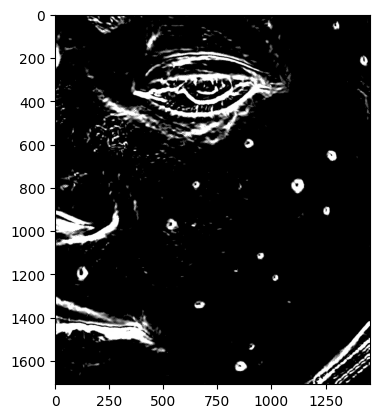

In [7]:
final_img=edgesy(img,blur)+edgesx(img,blur)
plot(final_img)

Step 4: Boost edges and fill them if are blacks spots around a edge

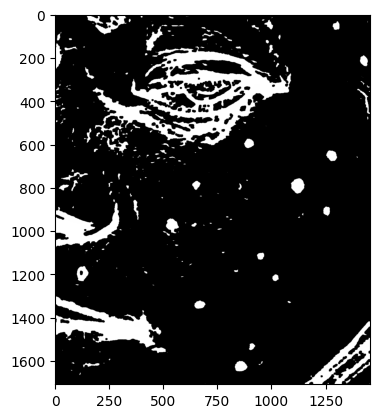

In [8]:
kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10)) #padding kernel 
opening = cv.morphologyEx(final_img, cv.MORPH_CLOSE, kernel) # boost the edges 
plot(opening)

Step 5: remove small white dots

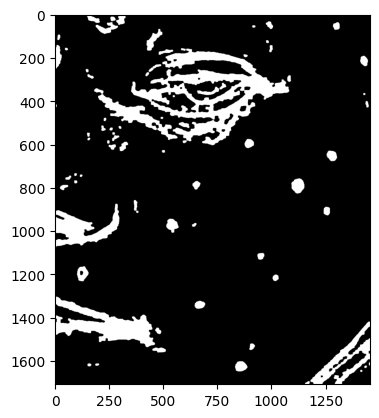

In [9]:
opening = cv.morphologyEx(opening, cv.MORPH_OPEN, kernel) # remove small white dots
plot(opening)

Step 6: find the contours

In [10]:
contours,_=cv.findContours(opening,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)


In [13]:
moles=[] # list of the mole contours
pix=len(img)*len(img[1]) #total pixels
count_mole=0

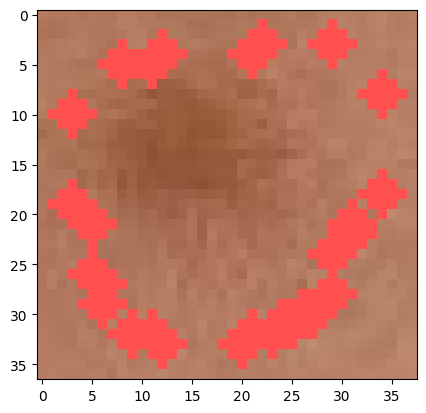

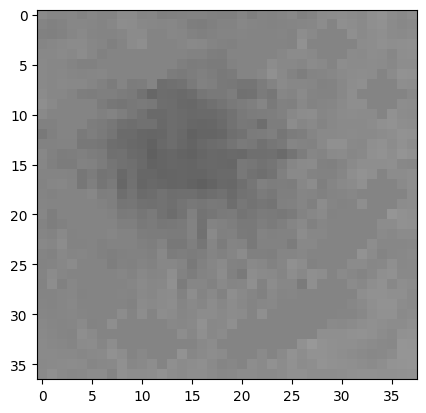

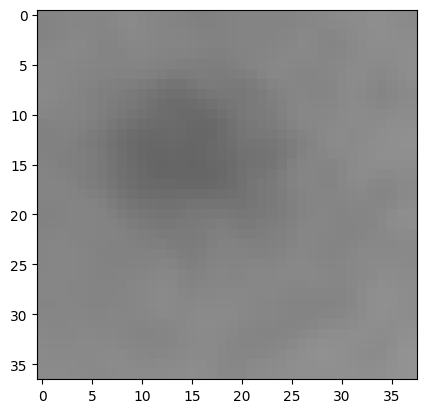

In [39]:
i = contours[15]
M=cv.moments(i)# chose a random contour
if M['m00']!=0: # zero means like dot contour
    a=M['m00'] # area in pixels
    x,y,w,h = cv.boundingRect(i) # 4 edges of the contour
    if a/(pix) < 0.005  and x+w<img.shape[1]-2 and x>0: #when the image is taken from distance, we dont expect large objects, thus we had add a threshold of 0.005, 
        X=(x,x+w,w)
        Y=(y,y+h,h)
        step_y=int(round(0.1*Y[2],0)) # depending the the size, the step is defined to crop the image
        step_x=int(round(0.1*X[2],0))
        if Y[0]==0 or X[0]==0:
            croped2=img[(Y[0]):(Y[1]+step_y),(X[0]):(X[1]+step_x)]
        elif step_x>X[0] and step_y<Y[0]:
            croped2=img[(Y[0]-step_y):(Y[1]+step_y),(X[0]-(step_x-5)):(X[1]+step_x)]
        elif Y[0]-step_y<0 or X[0]-step_x<0:
            croped2=img[(Y[0]-1):(Y[1]+step_y),(X[0]-1):(X[1]+step_x)]
        else:
            croped2=img[(Y[0]-step_y):(Y[1]+step_y),(X[0]-step_x):(X[1]+step_x)]
        plot(croped2)
        croped2=cv.cvtColor(croped2,cv.COLOR_BGR2GRAY) # blur (smoothing)
        plot(croped2)
        croped2= cv.GaussianBlur(croped2,(5,5),0) # blur (smoothing)
        plot(croped2)


now we are goinf to see if the croped image is mole or not

The idea is that a mole will loke like the plot below, this kind of paterns we indentifie as moles

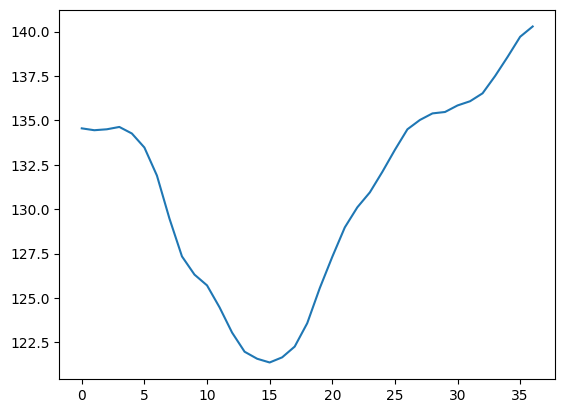

In [46]:
gaus=np.mean(croped2,axis=1)
plt.plot(gaus)

we take the midle value as starting point for the loop. We are doing this to prevent noise that could probably be in the edges of the vector, also

if the croped image is mole, we prior excpect that the distribution of the grayscale will look like inverted Gaus bell. 


123.0
15


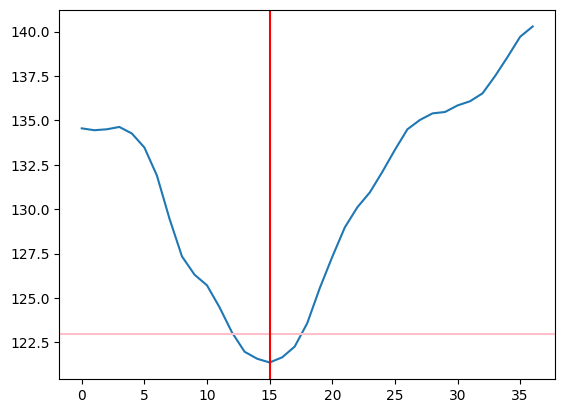

In [58]:
pivot1=round(min(gaus)+(max(gaus)-min(gaus))*0.1,0)
print(pivot1)
pivot2=np.where(gaus==min(gaus))[0][0]
print(pivot2)
plt.plot(gaus)
plt.axhline(y=pivot1,color="pink")
plt.axvline(x=pivot2,color="red")


In [60]:
count=0
for j in range(pivot2+1,len(gaus)):
    if gaus[j]>pivot1:
        count+=1
print(count)
t2botm=abs(gaus[0]-gaus[-1])/(max(gaus)-min(gaus))
print(t2botm)

19
0.30319888734353234


the threshold below ahve been difed empiracly, after a lot of test, of course they need to be dynamice. 

In [ ]:
if t2botm<0.399:
    if max(gaus)-min(gaus)>16.1 and count/len(gaus)>0.25 and count/len(gaus)<0.551 and count>7:

        moles.append(i)
    elif max(gaus)-min(gaus)>11 and count/len(gaus)>0.299 and count/len(gaus)<0.599 and count>10 and len(gaus)<63 and t2botm<0.15:

        moles.append(i)
    elif max(gaus)-min(gaus)>11 and count/len(gaus)>0.399 and count/len(gaus)<0.5299 and count>10 and len(gaus)<55 and t2botm<0.299:
    
        moles.append(i)
    elif max(gaus)-min(gaus)>25 and max(gaus)-min(gaus)<100 and count/len(gaus)>0.16 and count/len(gaus)<0.5  and count>4 and count<80:

        moles.append(i)
    elif (max(gaus)-min(gaus))>21 and count/len(gaus)>0.32 and count/len(gaus)<0.70  and count>10 and count<80 and len(gaus)<70:

        moles.append(i)

Final Step: Make a function that does the same for all the contours

In [61]:
def moles_detector(img):
    font = cv.FONT_HERSHEY_SIMPLEX
    kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(10,10))
    gray1=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    blur=cv.GaussianBlur(gray1,(31,31),0)
    final_img=edgesy(img,blur)+edgesx(img,blur)
    opening = cv.morphologyEx(final_img, cv.MORPH_CLOSE, kernel)
    opening = cv.morphologyEx(opening, cv.MORPH_OPEN, kernel)
    contours,_=cv.findContours(opening,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

    moles=[]
    pix=len(img)*len(img[1])
    mole1=0
    for i in contours:
        M=cv.moments(i)

        if M['m00']!=0:
            a=M['m00']

            x,y,w,h = cv.boundingRect(i)

            if a/(pix) < 0.005  and x+w<img.shape[1]-2 and x>0:
                #cordinate=(x,y,x+w,y+h)
                X=(x,x+w,w)
                Y=(y,y+h,h)
                step_y=int(round(0.1*Y[2],0))
                step_x=int(round(0.1*X[2],0))
                if Y[0]==0 or X[0]==0:
                    croped2=img[(Y[0]):(Y[1]+step_y),(X[0]):(X[1]+step_x)]
                elif step_x>X[0] and step_y<Y[0]:
                    croped2=img[(Y[0]-step_y):(Y[1]+step_y),(X[0]-(step_x-5)):(X[1]+step_x)]
                elif Y[0]-step_y<0 or X[0]-step_x<0:
                    croped2=img[(Y[0]-1):(Y[1]+step_y),(X[0]-1):(X[1]+step_x)]
                else:
                    croped2=img[(Y[0]-step_y):(Y[1]+step_y),(X[0]-step_x):(X[1]+step_x)]
                croped2=cv.cvtColor(croped2,cv.COLOR_BGR2GRAY)
                croped2= cv.GaussianBlur(croped2,(5,5),0)#to eixa 3,3
                gaus=np.mean(croped2,axis=1)
                pivot1=round(min(gaus)+(max(gaus)-min(gaus))*0.1,0)
                count=0
                pivot2=np.where(gaus==min(gaus))[0][0]
                for j in range(pivot2+1,len(gaus)):
                    if gaus[j]>pivot1:
                        count+=1
                t2botm=abs(gaus[0]-gaus[-1])/(max(gaus)-min(gaus))
                if t2botm<0.399:
                    if max(gaus)-min(gaus)>16.1 and count/len(gaus)>0.25 and count/len(gaus)<0.551 and count>7:

                        moles.append(i)
                    elif max(gaus)-min(gaus)>11 and count/len(gaus)>0.299 and count/len(gaus)<0.599 and count>10 and len(gaus)<63 and t2botm<0.15:

                        moles.append(i)
                    elif max(gaus)-min(gaus)>11 and count/len(gaus)>0.399 and count/len(gaus)<0.5299 and count>10 and len(gaus)<55 and t2botm<0.299:
    
                        moles.append(i)
                    elif max(gaus)-min(gaus)>25 and max(gaus)-min(gaus)<100 and count/len(gaus)>0.16 and count/len(gaus)<0.5  and count>4 and count<80:

                        moles.append(i)
                    elif (max(gaus)-min(gaus))>21 and count/len(gaus)>0.32 and count/len(gaus)<0.70  and count>10 and count<80 and len(gaus)<70:

                        moles.append(i)
                mole1+=1
    mole =0
    for mm in moles:
        x,y = mm[0],mm[0]
        mole+=1
        cv.drawContours(img,mm,-1,(79,79,255),3)
        cv.putText(img,str(mole),(list(x[0])[0],list(y[0])[1]-20), font, 2,(0,0,255),3,cv.LINE_AA)
    plot(img)


C:\Users\GeorgeXhixho\AppData\Local\Temp\ipykernel_6912\1985819901.py:39: RuntimeWarning: overflow encountered in ubyte_scalars
  der=(blur[row+h][col]-blur[row][col])/h
C:\Users\GeorgeXhixho\AppData\Local\Temp\ipykernel_6912\1985819901.py:18: RuntimeWarning: overflow encountered in ubyte_scalars
  der=(blur[i][j+h]-blur[i][j])/h


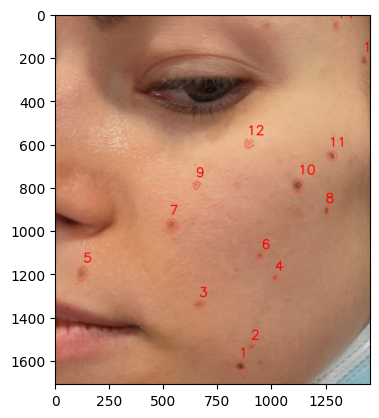

In [62]:
img=cv.imread('\\skin_test18.jpg')
img2=np.copy(img)
moles_detector(img)
